In [1]:
2+2

4

## RIVERS-PILOT EXPERIMENT OVERVIEW

    The rivers-pilot project runs the realistic SSC, v201812 (good bloom timing), from the following run directory:
        SS-run-sets/SalishSea/nemo3.6/tereza/RIVERS/RIVERS_pilot
        
    Restarts are from /results/SalishSea/nowcast-green.201812/31dec16
    
    There are two run scenarios, base and SHIFT, which use identical namelist.times and have the following diff patterns per yamls (base v SHIFT):
                < run_id: RP_base_1
            ---
            > run_id: RP_base_1_SHIFT
            20c20
            <     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_R201702/
            ---
            >     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_45Dearly/
            54c54
            <   - ./namelist.atmos_rivers
            ---
            >   - ./namelist.atmos_riversSHIFT
            
    The RIVERS_files are made in: 
        notebooks/RIVER_PAPER/RIVERS_pilot/make_daily_files and make_daily_files_shifted_hydrograph
    These use daily interpolated values from monthly averages, for all rivers except the fraser, where realistic 2017 values are used. 
    
    Then we shift the 'glacial' watersheds, as well as the Fraser river, forward 45 days to examine effects. 
        (not the rest of the fraser watershed; this is because Tereza forgot. 
        Not really a problem though, for a pilot run)
    The glacial watersheds are: wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    
    Results are stored in: /data/tjarniko/results/RIV_PIL
    
## NOTEBOOK OVERVIEW

    1. Here we first visualize the rivers in the SalishSeaCast model by watershed. 
    
    2. We then look at hydrograph patterns by watershed, identifying 
    the largest 5 rivers in each watershed by runoff.
    
    3. We then introduce the river_acid_observatory tool, which shows the hydgrograph of each river of interest 
    as well as key inorg. C cycle variables in the vicinity of its mouth: 
    S, nitrate, diatoms, TA-DIC, DIC, nDIC, and Omega.
    We consider two radii of importance: 3 grid cells from river mouth (~1.5 km) and 10 grid cells (5 km)
    The exception is the Fraser, where we have to consider a point not at the river mouth. 
    
    4. We apply the river_acid_observatory tool to the largest river in each watershed, 
    for both the BASE and the SHIFT runs. 
    
    5. We also build a river_flux_observatory tool, which shows the hydrograph of each river of interest 
    as well as key carbon air-sea flux variables in the vicinity of its mouth:  
    pCO2, delta-pCO2, wind strength, and flux. We apply this to the largest rivers in the watershed as well. 
    

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import sys
import numpy as np
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import glob
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')

import river_201702 as rv

## watershed map

In [4]:
def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            if rc==0: 
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],label = wsl[wc],marker='o')
                
            else:
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
                
            ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 10)
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    ax.scatter(300,425,s=100,c='k',label = 'Fraser-obs?',marker='*')
   

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cmap.set_bad('lightslategray')
    plt.legend(bbox_to_anchor=(1.29, 0.95))
    plt.suptitle(bigtit,fontsize=20)

In [5]:

watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        #print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1


gauge_riv = ['Squamish','SanJuan','Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene',\
            'Duckabush','Skokomish','DeerJohnsGoldboroughMill','Deschutes','Chambers',\
            'Chambers','NisquallyMcAllister','Puyallup','CedarSammamish','Skagit1',\
            'Samish','Stillaguamish1','SnohomishAllenQuilceda','Tulalip','Mission',\
            'Nooksack','Fraser','Oyster','Qunisam','SalmonSayward','Theodosia',
             'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman',
             'LittleQualicum','Puntledge']

cols = ['darkgray','red','powderblue','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

# Rivers in the SKOG model

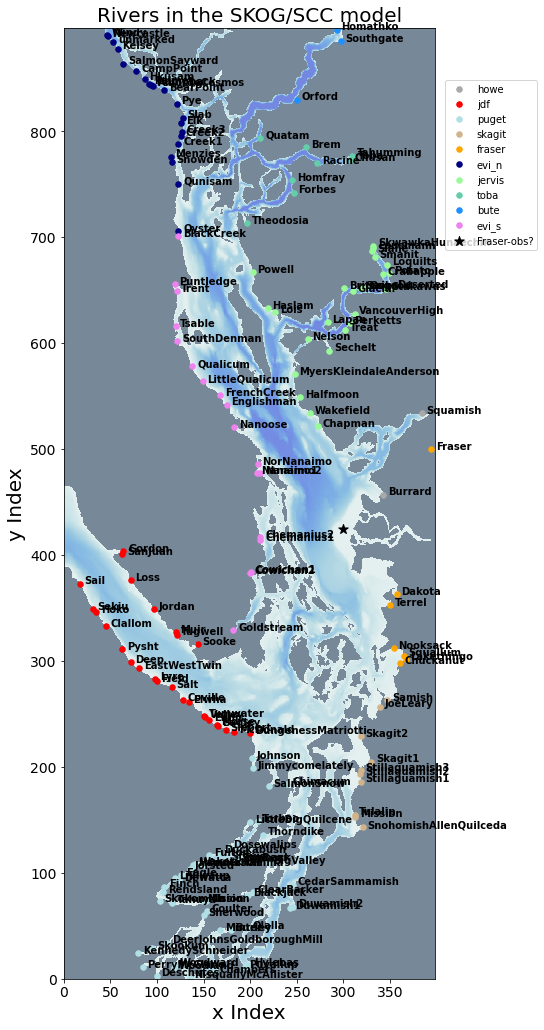

In [6]:
fact = 0.7
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'Rivers in the SKOG/SCC model', \
               cm.cm.dense,15*fact,25*fact,0,1000,'bathymetry','')

### calculate runoffs

In [7]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        
        
        if ((w == 'fraser') & (r == 'Fraser')):
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
            
            

## watersheds of the model, with 5 largest rivers labeled

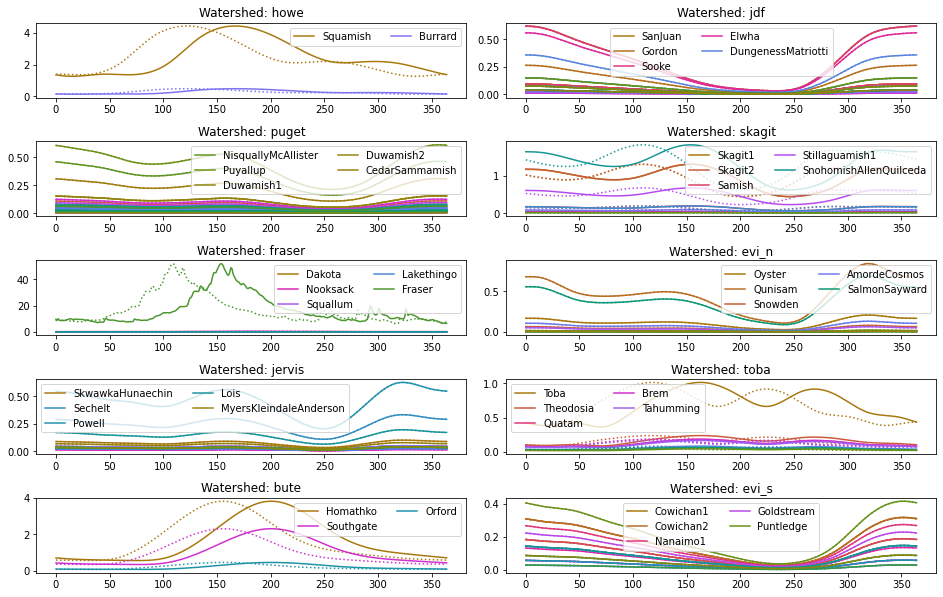

In [8]:
cmap = cm.cm.phase  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',\
        '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000',
       'black','mediumseagreen','olivedrab','yellow','saddlebrown']


fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    #print(biggest_riv)
    count = 0 
    numriv = np.size(rivlist)
    for riv in rivs:
        
        if riv in (biggest_riv):
            #yrprop = int((yr-1963) /(2018-1963) * 256)
            #print(int(count/numriv * 256))
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        else:
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        count = count+1
    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)
   

plt.tight_layout()

### watersheds of the model, showing only the top 5 rivers in each watershed

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
bute
['Homathko' 'Southgate' 'Orford']
evi_s
['Puntledge' 'Cowichan1' 'Cowichan2' 'Nanaimo1' 'Goldstream']


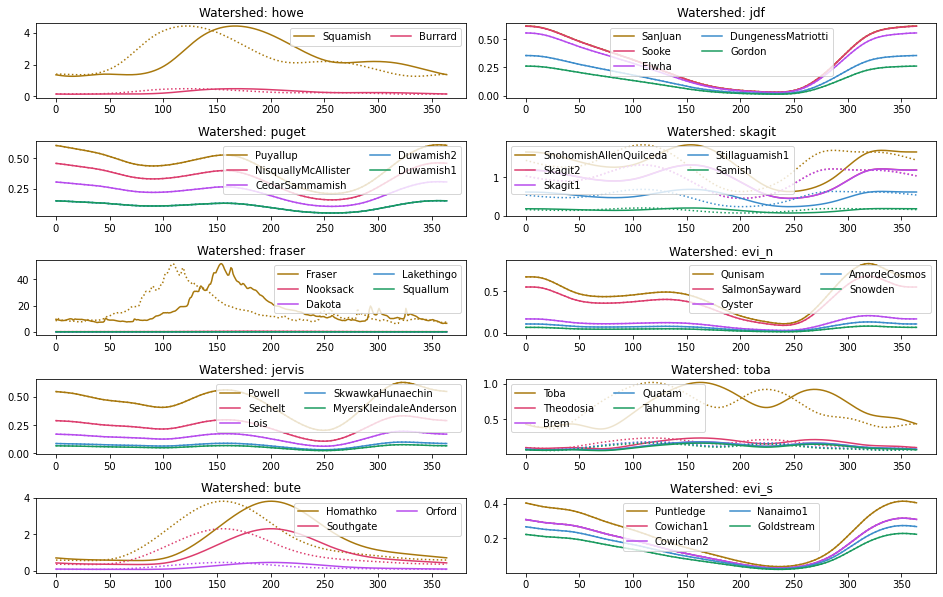

In [9]:
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    count = 0
    for riv in biggest_riv:
       
        #if riv in (biggest_riv):
        #print(count)
        #print(int(count/5 * 256))
        ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/5 * 256)])
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/5 * 256)])
        count = count+1

    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)

plt.tight_layout()

## extraction functions for rivers (extract_ts_BASE and extract_ts_SHIFT)

In [10]:
rv.prop_dict['jdf']['SanJuan']['j']

63

In [11]:
rv.prop_dict['howe']['Squamish']['j']


384

In [12]:
rv.prop_dict['howe']['Squamish']['i']

534

In [25]:
def extract_ts_BASE(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
        guess = '*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        print(w)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,0:5,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_SHIFT(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/FUTURE_runs/RIVER_2/*_RIVTA5/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,0:5,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_SHIFT_surf(start,end,vartyp,varnam,nam,wshed,rad):
    
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
        
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/FUTURE_runs/RIVER_2/*_RIVTA5/'
        guess = '*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        print(w)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_BASE_surf(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
    
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/FUTURE_runs/NEWBUDGET/*_RIVTA5/'
        guess = '*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

In [23]:
# w = nc.Dataset('/data/tjarniko/results/RIV_PIL/BASE/ncs/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170827-20170827.nc')

# print(w)

### calculate important properties for a given river and store in a dict.


In [19]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_RIV2_SHIFT_20170101_20171231'

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
mainrivlist = ['Homathko','Toba']

for w in watersheds:

    rivs = (clim_dict[w].keys())

    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    
    for tr in biggest_riv:
        if tr in mainrivlist:
            print(tr)
            pklnam = tr + appendix + '.pkl'
            print(pklnam)
        
            tr_dict = {}
            vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
            print(varnam)
            tr_dict['sal_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['sal_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)

            vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
            print(varnam)
            tr_dict['temp_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['temp_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)


            vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
            print(varnam)
            tr_dict['DIC_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['DIC_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)        


            vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
            print(varnam)
            tr_dict['TA_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['TA_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
            print(varnam)
            tr_dict['diatoms_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['diatoms_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
            print(varnam)
            tr_dict['nitrate_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['nitrate_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
            print(varnam)
            tr_dict['silicon_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['silicon_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 
            
            vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
            print(varnam)
            tr_dict['co2flux_rad3'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['co2flux_rad10'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad) 


            pickle.dump(tr_dict, open(pklnam, 'wb'))
        

        
        

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
Toba
Toba_RIV2_SHIFT_20170101_20171231.pkl
vosaline
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
votemper
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
2

['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170219-20170219.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170424-20170424.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170427-20170427.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170630-20170630.nc']
20170630
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170701-20170701.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170702-20170702.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170703-20170703.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170704-20170704.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170705-20170705.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170706-20170

['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170909-20170909.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170916-20170916.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171122-20171122.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171126-20171126.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171129-20171129.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170207-20170207.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170208-20170208.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170415-20170415.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170416-20170416.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170417-20170417.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170422-20170422.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170628-20170628.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170630-20170630.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170901-20170901.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170902-20170902.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170903-20170903.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170904-20170904.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170905-20170905.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170906-20170906.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170907-20170907.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170908-20170908.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171109-20171109.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171110-20171110.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171111-20171111.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171112-20171112.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171113-20171113.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171114-20171114.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171115-20171115.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171116-20171116.nc']


20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
nitrate
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
silicon
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
201

['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170309-20170309.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170314-20170314.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170522-20170522.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170523-20170523.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170524-20170524.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170525-20170525.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170526-20170526.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170527-20170

['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170802-20170802.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170809-20170809.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171014-20171014.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171015-20171015.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171018-20171018.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171019-20171019.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171021-20171021.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171220-20171220.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171222-20171222.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171223-20171223.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171227-20171227.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170305-20170305.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170309-20170309.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170311-20170311.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170522-20170

['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170725-20170725.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170726-20170726.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170727-20170727.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170728-20170728.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170729-20170729.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171001-20171001.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171002-20171002.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171003-20171003.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171004-20171004.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171005-20171005.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171007-20171007.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171216-20171216.nc']


In [28]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_RIV2BASE_20170101_20171231'

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
mainrivlist = ['Homathko','Toba']

for w in watersheds:

    rivs = (clim_dict[w].keys())

    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    
    for tr in biggest_riv:
        if tr in mainrivlist:
            print(tr)
            pklnam = tr + appendix + '.pkl'
            print(pklnam)
        
            tr_dict = {}
            vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
            print(varnam)
            tr_dict['sal_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['sal_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)

            vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
            print(varnam)
            tr_dict['temp_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['temp_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)


            vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
            print(varnam)
            tr_dict['DIC_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['DIC_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)        


            vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
            print(varnam)
            tr_dict['TA_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['TA_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
            print(varnam)
            tr_dict['diatoms_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['diatoms_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
            print(varnam)
            tr_dict['nitrate_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['nitrate_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
            print(varnam)
            tr_dict['silicon_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['silicon_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 
            
            vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
            print(varnam)
            tr_dict['co2flux_rad3'] = extract_ts_BASE_surf(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['co2flux_rad10'] = extract_ts_BASE_surf(start,end,vartyp,varnam,tr,w,rad) 


            pickle.dump(tr_dict, open(pklnam, 'wb'))
        

        
        

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
Toba
Toba_RIV2BASE_20170101_20171231.pkl
vosaline
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170102-20170102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170103-20170103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGE

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170305-20170305.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170509-20170509.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170512-20170512.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170713-20170713.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170716-20170716.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170916-20170916.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170919-20170919.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171122-20171122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_2017112

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170126-20170126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170127-20170127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170128-20170128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170129-20170129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_2017013

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170401-20170401.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170402-20170402.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170403-20170403.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170404-20170404.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170605-20170605.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170606-20170606.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170607-20170607.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170608-20170608.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170809-20170809.nc']
20170809
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170810-20170810.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170811-20170811.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170812-20170812.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171014-20171014.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171015-20171015.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171018-20171018.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171218-20171218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171219-20171219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171220-20171220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171222-20171222.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_2017122

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170219-20170219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170220-20170220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170221-20170221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170222-20170222.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170223-20170223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170224-20170224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170225-20170225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_2017022

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170427-20170427.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170428-20170428.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170429-20170429.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170430-20170430.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170501-20170501.nc']
20170501
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170630-20170630.nc']
20170630
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170701-20170701.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170702-20170702.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170703-20170703.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170704-20170704.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170705-20170705.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170902-20170902.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170903-20170903.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170904-20170904.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170905-20170905.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170906-20170906.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170907-20170907.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170908-20170908.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_2017090

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171108-20171108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171109-20171109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171110-20171110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171111-20171111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171112-20171112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171113-20171113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171114-20171114.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_2017111

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170112-20170112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170113-20170113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170114-20170114.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170115-20170115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170116-20170116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170117-20170117.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170118-20170118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170318-20170318.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170319-20170319.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170320-20170320.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170321-20170321.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170322-20170322.nc']
20170322
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170323-20170323.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170324-20170324.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170522-20170522.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170523-20170523.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170524-20170524.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170525-20170525.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170526-20170526.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170527-20170527.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170528-20170528.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_2017052

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170726-20170726.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170727-20170727.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170728-20170728.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170729-20170729.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170730-20170730.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170731-20170731.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170801-20170801.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20170929-20170929.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171001-20171001.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171002-20171002.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171003-20171003.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171004-20171004.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171005-20171005.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171205-20171205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171206-20171206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171207-20171207.nc']
20171207
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171208-20171208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170208-20170208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170209-20170209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170210-20170210.nc']
20170210
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170211-20170211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170414-20170414.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170415-20170415.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170416-20170416.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170417-20170417.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170618-20170618.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170619-20170619.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170620-20170620.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170621-20170621.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170622-20170622.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170822-20170822.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170823-20170823.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170824-20170824.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170825-20170825.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170826-20170826.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170827-20170827.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171028-20171028.nc']
20171028
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171029-20171029.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171030-20171030.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171031-20171031.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171101-20171101.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171102-20171102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170102-20170102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170103-20170103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170104-20170104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170309-20170309.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170512-20170512.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170513-20170513.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170514-20170514.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170716-20170716.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170717-20170717.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170919-20170919.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170920-20170920.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171126-20171126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170128-20170128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170129-20170129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170130-20170130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170131-20170131.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_2017020

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170403-20170403.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170404-20170404.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170405-20170405.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170406-20170406.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170407-20170407.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170408-20170408.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_2017041

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170607-20170607.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170608-20170608.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170609-20170609.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170610-20170610.nc']
20170610
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170611-20170611.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170612-20170612.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170811-20170811.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170812-20170812.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170813-20170813.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170814-20170814.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170815-20170815.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170816-20170816.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_2017081

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171018-20171018.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171019-20171019.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171021-20171021.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171222-20171222.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171223-20171223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170224-20170224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170225-20170225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170226-20170226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170430-20170430.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170501-20170501.nc']
20170501
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170502-20170502.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170503-20170503.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170504-20170504.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170704-20170704.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170705-20170705.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170706-20170706.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170907-20170907.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170908-20170908.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170909-20170909.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_2017091

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171113-20171113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171114-20171114.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171115-20171115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171116-20171116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171117-20171117.nc']
20171117
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170117-20170117.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170118-20170118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170119-20170119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170120-20170120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170121-20170121.nc']
20170121
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170323-20170323.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170324-20170324.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170325-20170325.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170326-20170326.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170327-20170327.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_2017033

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170527-20170527.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170528-20170528.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170529-20170529.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170530-20170530.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170531-20170531.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170731-20170731.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170801-20170801.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170802-20170802.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171004-20171004.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171005-20171005.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171007-20171007.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171008-20171008.nc']
20171008
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171009-20171009.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017121

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_2017021

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170424-20170424.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170622-20170622.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170628-20170628.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170826-20170826.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170827-20170827.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170829-20170829.nc']
20170829
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170830-20170830.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170831-20170831.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170901-20170901.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171101-20171101.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171102-20171102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171104-20171104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171105-20171105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171106-20171106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171107-20171107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017110

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170108-20170108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170109-20170109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170110-20170110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170111-20170111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170314-20170314.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170315-20170315.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170316-20170316.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170317-20170317.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170725-20170725.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170928-20170928.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170929-20170929.nc']
['

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171201-20171201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171202-20171202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171203-20171203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171204-20171204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170207-20170207.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_2017020

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170407-20170407.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170408-20170408.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170410-20170410.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170411-20170411.nc']
20170411
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170412-20170412.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170413-20170413.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170611-20170611.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170612-20170612.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170614-20170614.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170615-20170615.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170616-20170616.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170617-20170617.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017061

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170815-20170815.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170816-20170816.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170818-20170818.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170819-20170819.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170820-20170820.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170821-20170821.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171021-20171021.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171024-20171024.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171025-20171025.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171026-20171026.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171027-20171027.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171228-20171228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171229-20171229.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171230-20171230.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170305-20170305.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170503-20170503.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170504-20170504.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170509-20170509.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170713-20170713.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170916-20170916.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_2017091

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171116-20171116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171117-20171117.nc']
20171117
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171122-20171122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170120-20170120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170121-20170121.nc']
20170121
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170126-20170126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170326-20170326.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170327-20170327.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170401-20170401.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170530-20170530.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170531-20170531.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170605-20170605.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170809-20170809.nc']
20170809
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171007-20171007.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171008-20171008.nc']
20171008
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171009-20171009.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171014-20171014.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171218-20171218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017121

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170211-20170211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_2017021

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170417-20170417.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170621-20170621.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170622-20170622.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170825-20170825.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170826-20170826.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170827-20170827.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170829-20170829.nc']
20170829
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170830-20170830.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170831-20170831.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171031-20171031.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171101-20171101.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171102-20171102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171104-20171104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171105-20171105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171106-20171106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_2017110

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170104-20170104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170108-20170108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170109-20170109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170110-20170110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170314-20170314.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170315-20170315.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170316-20170316.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170514-20170514.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_2017052

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20170928-2017092

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171201-20171201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171202-20171202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171203-20171203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170131-20170131.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_2017020

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170406-20170406.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170407-20170407.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170408-20170408.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170410-20170410.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170411-20170411.nc']
20170411
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170412-20170412.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170610-20170610.nc']
20170610
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170611-20170611.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170612-20170612.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170614-20170614.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170615-20170615.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170616-20170616.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170814-20170814.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170815-20170815.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170816-20170816.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170818-20170818.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170819-20170819.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170820-20170820.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171019-20171019.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171021-20171021.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171024-20171024.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171025-20171025.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171026-20171026.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171223-20171223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_grid_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_grid_T_20171228-20171228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_grid_T_20171229-20171229.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170226-20170226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170502-20170502.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170503-20170503.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170504-20170504.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_2017050

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170706-20170706.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170909-20170909.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_2017091

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171115-20171115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171116-20171116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171117-20171117.nc']
20171117
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170119-20170119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170120-20170120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170121-20170121.nc']
20170121
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170325-20170325.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170326-20170326.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170327-20170327.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170529-20170529.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170530-20170530.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170531-20170531.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170802-20170802.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171007-20171007.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171008-20171008.nc']
20171008
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171009-20171009.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_2017121

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170219-20170219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170220-20170220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_2017022

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170424-20170424.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170628-20170628.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170630-20170630.nc']
20170630
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170829-20170829.nc']
20170829
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170830-20170830.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170831-20170831.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170901-20170901.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170902-20170902.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170903-20170903.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171104-20171104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171105-20171105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171106-20171106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171107-20171107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171108-20171108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171109-20171109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_2017111

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170108-20170108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170109-20170109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170110-20170110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170111-20170111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170112-20170112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170113-20170113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170314-20170314.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170315-20170315.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170316-20170316.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170317-20170317.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170318-20170318.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170319-20170319.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_2017032

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170522-20170522.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170523-20170523.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170725-20170725.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170726-20170726.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170727-20170727.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_2017072

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20170928-20170928.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20170929-20170929.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171001-20171001.nc']
['/data/tjarniko/res

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171201-20171201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171202-20171202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171203-20171203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171204-20171204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171205-20171205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171206-20171206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170207-20170207.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170208-20170208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170209-20170209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_2017021

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170410-20170410.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170411-20170411.nc']
20170411
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170412-20170412.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170413-20170413.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170414-20170414.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170415-20170415.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170614-20170614.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170615-20170615.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170616-20170616.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170617-20170617.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170618-20170618.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170619-20170619.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170818-20170818.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170819-20170819.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170820-20170820.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170821-20170821.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170822-20170822.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170823-20170823.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171024-20171024.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171025-20171025.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171026-20171026.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171027-20171027.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171028-20171028.nc']
20171028
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171029-20171029.nc']
['/data/tjarniko/results/FUTU

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171228-20171228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171229-20171229.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171230-20171230.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171231-20171231.nc']
diatoms
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_201701

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170305-20170305.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170509-20170509.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170713-20170713.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170916-20170916.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171122-20171122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017112

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170126-20170126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170127-20170127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170128-20170128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_2017012

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170401-20170401.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170402-20170402.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170403-20170403.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170605-20170605.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170606-20170606.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170607-20170607.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170809-20170809.nc']
20170809
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170810-20170810.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170811-20170811.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171014-20171014.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171015-20171015.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171218-20171218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171219-20171219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171220-20171220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017122

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170219-20170219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170220-20170220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170221-20170221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170222-20170222.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170223-20170223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170224-20170224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_2017022

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170424-20170424.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170427-20170427.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170428-20170428.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170429-20170429.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170430-20170430.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_2017050

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170628-20170628.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170630-20170630.nc']
20170630
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170701-20170701.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170702-20170702.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170703-20170703.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170704-20170704.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170901-20170901.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170902-20170902.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170903-20170903.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170904-20170904.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170905-20170905.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170906-20170906.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170907-20170907.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_2017090

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171107-20171107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171108-20171108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171109-20171109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171110-20171110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171111-20171111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171112-20171112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171113-20171113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017111

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170111-20170111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170112-20170112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170113-20170113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170114-20170114.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170115-20170115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170116-20170116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170117-20170117.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170317-20170317.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170318-20170318.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170319-20170319.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170320-20170320.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170321-20170321.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170322-20170322.nc']
20170322
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170323-20170323.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170522-20170522.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170523-20170523.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170524-20170524.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170525-20170525.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170526-20170526.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170527-20170527.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170725-20170725.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170726-20170726.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170727-20170727.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170728-20170728.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170729-20170729.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170730-20170730.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170731-20170731.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170928-20170928.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170929-20170929.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171001-20171001.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171002-20171002.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171003-20171003.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171004-20171004.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171005-20171005.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171204-20171204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171205-20171205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171206-20171206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171207-20171207.nc']
20171207
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171208-20171208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170207-20170207.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170208-20170208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170209-20170209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170210-20170210.nc']
20170210
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170211-20170211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170413-20170413.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170414-20170414.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170415-20170415.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170416-20170416.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170417-20170417.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170617-20170617.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170618-20170618.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170619-20170619.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170620-20170620.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170621-20170621.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170622-20170622.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170821-20170821.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170822-20170822.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170823-20170823.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170824-20170824.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170825-20170825.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170826-20170826.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170827-20170827.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171027-20171027.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171028-20171028.nc']
20171028
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171029-20171029.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171030-20171030.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171031-20171031.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171101-20171101.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171102-20171102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017110

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171231-20171231.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170102-20170102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170103-20170103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170104-20170104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170309-20170309.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170512-20170512.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170513-20170513.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170514-20170514.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170716-20170716.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170717-20170717.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170919-20170919.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170920-20170920.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171126-20171126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017113

## calculate spec. for fraser. 

In [20]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_RIV2SHIFT_20170101_20171231'


w = 'fraser'
tr = 'Fraser'

print(tr)
pklnam = tr + appendix + '.pkl'
print(pklnam)

tr_dict = {}
vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
print(varnam)
tr_dict['sal_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['sal_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)

vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
print(varnam)
tr_dict['temp_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['temp_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)


vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
print(varnam)
tr_dict['DIC_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['DIC_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)        


vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
print(varnam)
tr_dict['TA_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['TA_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
print(varnam)
tr_dict['diatoms_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['diatoms_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
print(varnam)
tr_dict['nitrate_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['nitrate_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
print(varnam)
tr_dict['silicon_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['silicon_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 
            
vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
print(varnam)
tr_dict['co2flux_rad3'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['co2flux_rad10'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad) 


pickle.dump(tr_dict, open(pklnam, 'wb'))


        
        

Fraser
Fraser_RIV2SHIFT_20170101_20171231.pkl
vosaline
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
votemper
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
dissolved_inorganic_carbon
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411


['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170222-20170222.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170223-20170223.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170224-20170224.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170225-20170225.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170226-20170226.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170301-20170301.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170509-20170509.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170512-20170512.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170513-20170513.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170514-20170514.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170713-20170713.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170716-20170716.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170717-20170717.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170720-20170720.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20170928-20170928.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20170929-20170929.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28sep17_RIVTA5/SalishSeaCast_1d_20170928_20171027_carp_T_20171001-20171001.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171207-20171207.nc']
20171207
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171208-20171208.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171214-20171

['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170219-20170219.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170220-20170220.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170221-20170221.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170222-20170222.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170223-20170223.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170427-20170427.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170428-20170428.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170429-20170429.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170430-20170430.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170501-20170501.nc']
20170501
['/data/tjarniko/results/FUTURE_runs/RIVER_2/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170502-20170

['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170706-20170706.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170713-20170713.nc']


['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170919-20170919.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170920-20170920.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170924-20170

['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171126-20171126.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/RIVER_2/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171201-20171201.nc']


In [29]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_RIV2BASE_20170101_20171231'


w = 'fraser'
tr = 'Fraser'

print(tr)
pklnam = tr + appendix + '.pkl'
print(pklnam)

tr_dict = {}
vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
print(varnam)
tr_dict['sal_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['sal_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)

vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
print(varnam)
tr_dict['temp_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['temp_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)


vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
print(varnam)
tr_dict['DIC_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['DIC_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)        


vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
print(varnam)
tr_dict['TA_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['TA_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
print(varnam)
tr_dict['diatoms_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['diatoms_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
print(varnam)
tr_dict['nitrate_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['nitrate_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
print(varnam)
tr_dict['silicon_rad3'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['silicon_rad10'] = extract_ts_BASE(start,end,vartyp,varnam,tr,w,rad) 
            
vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
print(varnam)
tr_dict['co2flux_rad3'] = extract_ts_BASE_surf(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['co2flux_rad10'] = extract_ts_BASE_surf(start,end,vartyp,varnam,tr,w,rad) 


pickle.dump(tr_dict, open(pklnam, 'wb'))


        
        

Fraser
Fraser_RIV2BASE_20170101_20171231.pkl
vosaline
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170102-20170102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170103-20170103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170104-20170104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/0

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170308-20170308.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170309-20170309.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170512-20170512.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170513-20170513.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170514-20170514.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170716-20170716.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170717-20170717.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170919-20170919.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170920-20170920.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171125-20171125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171126-20171126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_2017113

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170127-20170127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170128-20170128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170129-20170129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170130-20170130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170131-20170131.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_2017020

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170402-20170402.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170403-20170403.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170404-20170404.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170405-20170405.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170406-20170406.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170407-20170407.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170408-20170408.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170606-20170606.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170607-20170607.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170608-20170608.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170609-20170609.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170610-20170610.nc']
20170610
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170611-20170611.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170612-20170612.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170810-20170810.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170811-20170811.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170812-20170812.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170813-20170813.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170814-20170814.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170815-20170815.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170816-20170816.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_2017081

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171015-20171015.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171018-20171018.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171019-20171019.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171021-20171021.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171220-20171220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171222-20171222.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171223-20171223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_grid_T_2017122

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170223-20170223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170224-20170224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170225-20170225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170226-20170226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_grid_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_2017030

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170429-20170429.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_grid_T_20170430-20170430.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170501-20170501.nc']
20170501
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170502-20170502.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170503-20170503.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170504-20170504.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170703-20170703.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170704-20170704.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170705-20170705.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170706-20170706.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_grid_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170906-20170906.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170907-20170907.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170908-20170908.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170909-20170909.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_grid_T_2017091

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171112-20171112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171113-20171113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171114-20171114.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171115-20171115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171116-20171116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171117-20171117.nc']
20171117
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170116-20170116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170117-20170117.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170118-20170118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170119-20170119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170120-20170120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170121-20170121.nc']
20170121
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170322-20170322.nc']
20170322
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170323-20170323.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170324-20170324.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170325-20170325.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170326-20170326.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170327-20170327.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_grid_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170526-20170526.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170527-20170527.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170528-20170528.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170529-20170529.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_grid_T_20170530-20170530.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170531-20170531.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_grid_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170730-20170730.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170731-20170731.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170801-20170801.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170802-20170802.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_grid_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171003-20171003.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171004-20171004.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171005-20171005.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171007-20171007.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171008-20171008.nc']
20171008
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171009-20171009.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_grid_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171208-20171208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171209-20171209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171210-20171210.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_grid_T_2017121

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170211-20170211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170212-20170212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170213-20170213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_2017021

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170417-20170417.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170418-20170418.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170419-20170419.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170621-20170621.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170622-20170622.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170623-20170623.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170825-20170825.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170826-20170826.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170827-20170827.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170829-20170829.nc']
20170829
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170830-20170830.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170831-20170831.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171031-20171031.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171101-20171101.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171102-20171102.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171104-20171104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171105-20171105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171106-20171106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_2017110

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170104-20170104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170105-20170105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170106-20170106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170108-20170108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170109-20170109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_20170110-20170110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_carp_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170310-20170310.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170311-20170311.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170312-20170312.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170314-20170314.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170315-20170315.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170316-20170316.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_2017031

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170514-20170514.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170515-20170515.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170516-20170516.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_2017052

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170718-20170718.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170719-20170719.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170720-20170720.nc']
20170720
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170921-20170921.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170922-20170922.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170923-20170923.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20170928-2017092

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171127-20171127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171128-20171128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171129-20171129.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171201-20171201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171202-20171202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171203-20171203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170131-20170131.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170201-20170201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170202-20170202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_2017020

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170406-20170406.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170407-20170407.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170408-20170408.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170410-20170410.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170411-20170411.nc']
20170411
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_T_20170412-20170412.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170610-20170610.nc']
20170610
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170611-20170611.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170612-20170612.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170614-20170614.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170615-20170615.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_T_20170616-20170616.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170814-20170814.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170815-20170815.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170816-20170816.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170818-20170818.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170819-20170819.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_20170820-20170820.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_carp_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171019-20171019.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171020-20171020.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171021-20171021.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171024-20171024.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171025-20171025.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_carp_T_20171026-20171026.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171223-20171223.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171224-20171224.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171225-20171225.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_carp_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171228-20171228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_T_20171229-20171229.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170226-20170226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170227-20170227.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170228-20170228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_carp_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170502-20170502.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170503-20170503.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170504-20170504.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_carp_T_2017050

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170706-20170706.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170707-20170707.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170708-20170708.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_carp_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170909-20170909.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170910-20170910.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170911-20170911.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_carp_T_2017091

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171115-20171115.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171116-20171116.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171117-20171117.nc']
20171117
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_carp_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170119-20170119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170120-20170120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170121-20170121.nc']
20170121
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170325-20170325.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170326-20170326.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170327-20170327.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170529-20170529.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170530-20170530.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170531-20170531.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170802-20170802.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170803-20170803.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170804-20170804.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017080

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171006-20171006.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171007-20171007.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171008-20171008.nc']
20171008
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171009-20171009.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171211-20171211.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171212-20171212.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171213-20171213.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171214-20171214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017121

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170214-20170214.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170215-20170215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170216-20170216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170217-20170217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170218-20170218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170219-20170219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170220-20170220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_2017022

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170420-20170420.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170421-20170421.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170422-20170422.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170423-20170423.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170424-20170424.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170425-20170425.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170426-20170426.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017042

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170624-20170624.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170625-20170625.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170626-20170626.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170627-20170627.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170628-20170628.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170629-20170629.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170630-20170630.nc']
20170630
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170828-20170828.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170829-20170829.nc']
20170829
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170830-20170830.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170831-20170831.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170901-20170901.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170902-20170902.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170903-20170903.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171103-20171103.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171104-20171104.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171105-20171105.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171106-20171106.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171107-20171107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171108-20171108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171109-20171109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017111

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170107-20170107.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170108-20170108.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170109-20170109.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170110-20170110.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170111-20170111.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170112-20170112.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170113-20170113.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_2017011

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170313-20170313.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170314-20170314.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170315-20170315.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170316-20170316.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170317-20170317.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170318-20170318.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170319-20170319.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_2017032

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170517-20170517.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170518-20170518.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170519-20170519.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170520-20170520.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170521-20170521.nc']
20170521
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170522-20170522.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170523-20170523.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170721-20170721.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170722-20170722.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170723-20170723.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170724-20170724.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170725-20170725.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170726-20170726.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170727-20170727.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_2017072

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170924-20170924.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170925-20170925.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170926-20170926.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170927-20170927.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170928-20170928.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170929-20170929.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20170930-20170930.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171001-20171001.nc']
['/data/tjarniko/res

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171130-20171130.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171201-20171201.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171202-20171202.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171203-20171203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171204-20171204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171205-20171205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171206-20171206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017120

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170203-20170203.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170204-20170204.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170205-20170205.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170206-20170206.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170207-20170207.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170208-20170208.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170209-20170209.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_2017021

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170409-20170409.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170410-20170410.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170411-20170411.nc']
20170411
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170412-20170412.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170413-20170413.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170414-20170414.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170415-20170415.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170613-20170613.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170614-20170614.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170615-20170615.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170616-20170616.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170617-20170617.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170618-20170618.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170619-20170619.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017062

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170817-20170817.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170818-20170818.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170819-20170819.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170820-20170820.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170821-20170821.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170822-20170822.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170823-20170823.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_2017082

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171022-20171022.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171023-20171023.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171024-20171024.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171025-20171025.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171026-20171026.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171027-20171027.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171028-20171028.nc']
20171028
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171029-20171029.nc']
['/data/tjarniko/results/FUTU

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171226-20171226.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171227-20171227.nc']
20171227
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171228-20171228.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171229-20171229.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171230-20171230.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27dec17_RIVTA5/SalishSeaCast_1d_20171227_20171231_ptrc_T_20171231-20171231.nc']
silicon
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170101-20170101.nc']
20170101
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_201701

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31jan17_RIVTA5/SalishSeaCast_1d_20170131_20170301_ptrc_T_20170301-20170301.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170302-20170302.nc']
20170302
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170303-20170303.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170304-20170304.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170305-20170305.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170306-20170306.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170307-20170307.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170505-20170505.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170506-20170506.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170507-20170507.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170508-20170508.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170509-20170509.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170510-20170510.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_20170511-20170511.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01may17_RIVTA5/SalishSeaCast_1d_20170501_20170530_ptrc_T_2017051

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170709-20170709.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170710-20170710.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170711-20170711.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170712-20170712.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170713-20170713.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170714-20170714.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_20170715-20170715.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jun17_RIVTA5/SalishSeaCast_1d_20170630_20170729_ptrc_T_2017071

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170912-20170912.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170913-20170913.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170914-20170914.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170915-20170915.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170916-20170916.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170917-20170917.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_T_20170918-20170918.nc']
20170918
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/29aug17_RIVTA5/SalishSeaCast_1d_20170829_20170927_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171118-20171118.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171119-20171119.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171120-20171120.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171121-20171121.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171122-20171122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171123-20171123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_20171124-20171124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28oct17_RIVTA5/SalishSeaCast_1d_20171028_20171126_ptrc_T_2017112

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170122-20170122.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170123-20170123.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170124-20170124.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170125-20170125.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170126-20170126.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170127-20170127.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_20170128-20170128.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01jan17_RIVTA5/SalishSeaCast_1d_20170101_20170130_ptrc_T_2017012

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170328-20170328.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170329-20170329.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170330-20170330.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/02mar17_RIVTA5/SalishSeaCast_1d_20170302_20170331_ptrc_T_20170331-20170331.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170401-20170401.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170402-20170402.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_20170403-20170403.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/01apr17_RIVTA5/SalishSeaCast_1d_20170401_20170430_ptrc_T_2017040

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170601-20170601.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170602-20170602.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170603-20170603.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170604-20170604.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170605-20170605.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170606-20170606.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_20170607-20170607.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/31may17_RIVTA5/SalishSeaCast_1d_20170531_20170629_ptrc_T_2017060

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170805-20170805.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170806-20170806.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170807-20170807.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170808-20170808.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170809-20170809.nc']
20170809
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170810-20170810.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170811-20170811.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/30jul17_RIVTA5/SalishSeaCast_1d_20170730_20170828_ptrc_

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171010-20171010.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171011-20171011.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171012-20171012.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171013-20171013.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171014-20171014.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171015-20171015.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171016-20171016.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_RIVTA5/SKOG_1d_20170928_20171027_ptrc_T_20171017-20171017.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/28sep17_R

['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171215-20171215.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171216-20171216.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171217-20171217.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171218-20171218.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171219-20171219.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171220-20171220.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_20171221-20171221.nc']
['/data/tjarniko/results/FUTURE_runs/NEWBUDGET/27nov17_RIVTA5/SalishSeaCast_1d_20171127_20171226_ptrc_T_2017122